## Chargement des données

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
import sys
import os
import pandas as pd
import ast
from dotenv import load_dotenv
load_dotenv()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from api.services.database_helper import get_all_vectors_from_db, connect_to_db

In [2]:
conn = connect_to_db()
all_data = get_all_vectors_from_db(conn)
print(type(all_data))

<class 'list'>


In [2]:
df = pd.read_csv("embedding.csv")
df.head()

,id,vector
0,52ef707a572da4e903000556,"[0.18677342,0.2172054,0.3031756,0.016607251,-0..."
1,52ef6f044ea6bfe52e00099c,"[-0.21022785,0.07977808,0.061076757,-0.1016258..."
2,52ef704d122bb64c4f00093a,"[0.23940459,0.22484551,0.2711723,0.03518518,-0..."
3,52efa289572da4e9030005ae,"[0.14386003,0.17271268,0.16389565,0.07044793,-..."
4,52ef71cd5c4baf9e610008a7,"[0.20130442,0.15990795,0.2808601,0.15049519,-0..."


In [4]:
from pymongo import MongoClient


# Connexion à MongoDB
mongo_url = os.getenv("MONGO_URL")  # Assurez-vous que la variable d'environnement est définie
client = MongoClient(mongo_url)
db = client["G1"]
collection = db["threads"]

# Récupérer tous les _id de la collection threads
valid_ids = set(doc["_id"] for doc in collection.find({}, {"_id": 1}))

# Garder uniquement les données dont l'id est dans valid_ids
# filtered_data = [item for item in all_data if item[0] in valid_ids]
filtered_data = df[df["id"].isin(valid_ids)]

print(type(filtered_data))
print(len(filtered_data))  # Vérifier combien de données ont été filtrées

<class 'pandas.core.frame.DataFrame'>
37218


In [5]:
# print(all_data[0])
# df = pd.DataFrame(all_data, columns=['id', 'vector'])
df['vector'] = df['vector'].apply(lambda x: ast.literal_eval(x))
print(df.head())

                         id                                             vector
0  52ef707a572da4e903000556  [0.18677342, 0.2172054, 0.3031756, 0.016607251...
1  52ef6f044ea6bfe52e00099c  [-0.21022785, 0.07977808, 0.061076757, -0.1016...
2  52ef704d122bb64c4f00093a  [0.23940459, 0.22484551, 0.2711723, 0.03518518...
3  52efa289572da4e9030005ae  [0.14386003, 0.17271268, 0.16389565, 0.0704479...
4  52ef71cd5c4baf9e610008a7  [0.20130442, 0.15990795, 0.2808601, 0.15049519...


## Application du k-means

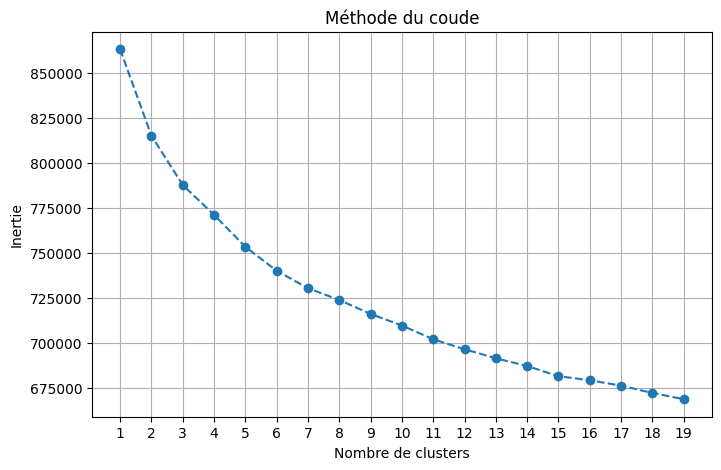

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculer l'inertie pour différents nombres de clusters
inertias = []
range_clusters = range(1, 20)

for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(list(df['vector']))
    inertias.append(kmeans.inertia_)

# Tracer la courbe de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertias, marker='o', linestyle='--')
plt.title("Méthode du coude")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.xticks(range_clusters)
plt.grid()
plt.show()

In [7]:
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(list(df['vector']))
df['cluster'] = kmeans.labels_
df.head()

,id,vector,cluster
0,52ef707a572da4e903000556,"[0.18677342, 0.2172054, 0.3031756, 0.016607251...",12
1,52ef6f044ea6bfe52e00099c,"[-0.21022785, 0.07977808, 0.061076757, -0.1016...",9
2,52ef704d122bb64c4f00093a,"[0.23940459, 0.22484551, 0.2711723, 0.03518518...",12
3,52efa289572da4e9030005ae,"[0.14386003, 0.17271268, 0.16389565, 0.0704479...",12
4,52ef71cd5c4baf9e610008a7,"[0.20130442, 0.15990795, 0.2808601, 0.15049519...",12


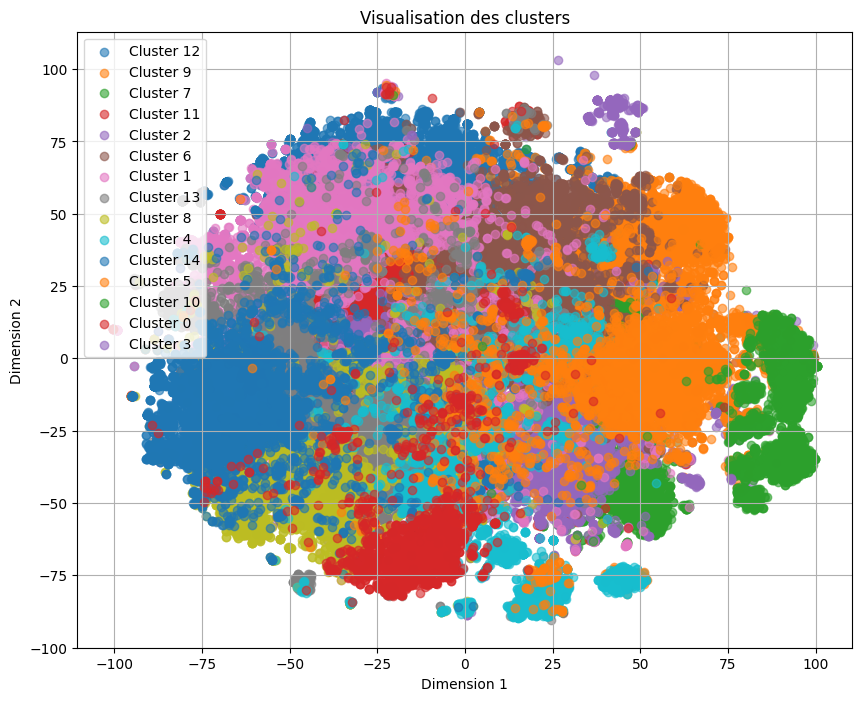

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(np.array(list(df['vector'])))

# Ajouter les coordonnées réduites au DataFrame
df['x'] = reduced_vectors[:, 0]
df['y'] = reduced_vectors[:, 1]

# Visualisation
plt.figure(figsize=(10, 8))
for cluster_id in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("Visualisation des clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid()
plt.show()

## Récupérer les autres données de chaque messages

In [27]:
mongo_url = os.getenv("MONGO_URL")
client = MongoClient(mongo_url)
db = client["G1"]
collection = db["threads"]

collection.find()
# mettre dans un dictionnaire pour un accès plus rapide
complete_data = {}
for doc in collection.find():
    complete_data[doc["_id"]] = doc["content"]["title"] if "content" in doc and "title" in doc["content"] else ""
    
df["title"] = ""
for index, row in df.iterrows():
    try:
        id = row["id"]
        df.at[index, "title"] = complete_data[id]
    except KeyError:
        print(row["id"])
        df.at[index, "title"] = ""
    
df.head()

52ef707a572da4e903000556
52ef704d122bb64c4f00093a
52efa289572da4e9030005ae
52ef71cd5c4baf9e610008a7
52efa287275c2a07680009a7
52f006f6b4907d2e23000aab
52ef70365e3e190135000814
52efa0cf4b4451380f00091a
52f20e77a3daba106c000b86
52f66ecaa3daba106c000d84
52ef9c9c4b4451380f000915
52ef73dad75e29d72b0009b5
52ef7782275c2a076800096c
52ef72dca3daba106c00094a
52ef721ed75e29d72b0009ad
52efc4aee0134f452c00096b
52efc68e91f923142b0009b8
52f0cf7f122bb64c4f000ac5
52f11611be245c9d39000b21
52f1245f122bb64c4f000b18
52f398d3275c2a0768000c81
52f3b801a4e1ab1d30000be0
52f135fbb4907d2e23000b98
52efbc734ea6bfe52e000a31
52f0221a4ea6bfe52e000b0e
52f0ee12b4907d2e23000b54
52f3e657b4907d2e23000d14
52ef82215e3e190135000833
52ef8130ab137b0072000817
52ef99d4cfc81d7e41000993
52efbeb9327311bc400007d6
52f5336a4b4451380f000cc3
52efcb4e122bb64c4f0009ea
52f0f1984ea6bfe52e000b82
52f538194ea6bfe52e000d95
52f3bb905e3e190135000b3b
52f4d2c1b4907d2e23000d67
52f6adbbcfc81d7e41000da5
5344565aab137bdb59000067
52f0b305a4e1ab1d300009e2


,id,vector,cluster,x,y,title
0,52ef707a572da4e903000556,"[0.18677342, 0.2172054, 0.3031756, 0.016607251...",12,-5.882454,78.022552,
1,52ef6f044ea6bfe52e00099c,"[-0.21022785, 0.07977808, 0.061076757, -0.1016...",9,37.688126,22.276814,Presentation: Ulrich R.
2,52ef704d122bb64c4f00093a,"[0.23940459, 0.22484551, 0.2711723, 0.03518518...",12,-5.880582,78.032867,
3,52efa289572da4e9030005ae,"[0.14386003, 0.17271268, 0.16389565, 0.0704479...",12,-4.317370,74.513901,
4,52ef71cd5c4baf9e610008a7,"[0.20130442, 0.15990795, 0.2808601, 0.15049519...",12,-4.539421,74.011383,


In [28]:
df["title"].value_counts()

title
                                             46202
Présentation                                  1287
Peter                                          705
Anne                                           624
Introduction                                   531
                                             ...  
Votre document "RESSOURCES GRATUITES.PDF"        1
Séverine                                         1
que de théories!                                 1
Joindre l'utile à l'agréable...                  1
Stéphane, Manager ?                              1
Name: count, Length: 27442, dtype: int64